[[[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 ...

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]]


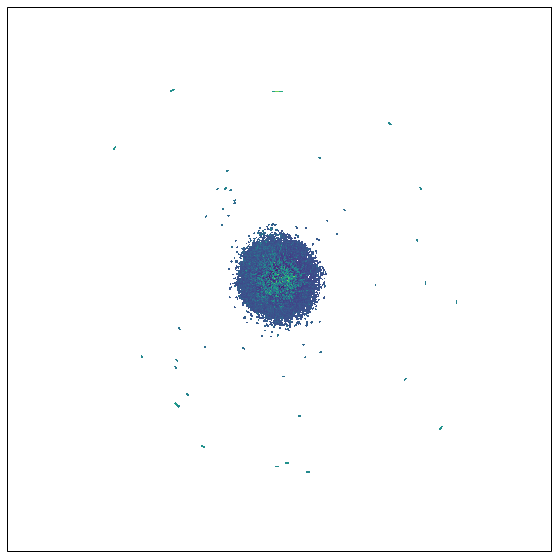

In [5]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from siphon.catalog import TDSCatalog
from siphon.radarserver import RadarServer
from siphon.cdmr import Dataset
from metpy.plots import ctables, add_timestamp, add_metpy_logo
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import numpy as np
import rasterio as rio

cat = TDSCatalog('https://thredds.ucar.edu/thredds/radarServer/catalog.xml')

rs = RadarServer(cat.catalog_refs['NEXRAD Level III Radar from IDD'].href)

query = rs.query()
now = datetime.utcnow()
query.stations('SGF').time(now).variables('N0Q')

query_cat = rs.get_catalog(query)
data = query_cat.datasets[0].remote_access()
field_name = 'BaseReflectivityDR'

range_data = data.variables['gate'][:]
azimuth_data = data.variables['azimuth'][:]
radar_data = data.variables[field_name][:]

x = range_data * np.sin(np.deg2rad(azimuth_data))[:, None]
y = range_data * np.cos(np.deg2rad(azimuth_data))[:, None]

radar_data = np.ma.array(radar_data, mask=np.isnan(radar_data))

proj = ccrs.LambertConformal(central_longitude=data.RadarLongitude,
                                    central_latitude=data.RadarLatitude)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, projection=proj)
mesh = ax.pcolormesh(x, y, radar_data, zorder=0)

# Get pixels into a numpy array
fig.canvas.draw()
raster = np.array(fig.canvas.renderer._renderer)

# fig2 = plt.figure()
# ax2 = fig2.add_subplot(111, frameon=False)
# ax2.imshow(raster)
# plt.show()

print(raster)

geotiff = rio.open('geotiff.tif', 'w', driver='GTiff',
                   height=raster.shape[0], width=raster.shape[1], 
                   count=raster.shape[2], dtype=raster.dtype, crs='+proj=latlong')

geotiff.close()

